# Tracking a halo for zoom-in simulations

In order to simulate galaxy evolution in a realistic environment, there's a few steps to run through first. 

1) Run a low-ish resolution simulation of a large cosmological box to generate some halos.

2) Perform some visual inspection to find halos that aren't significantly disrupted by mergers or their host cluster (unless you're into that sort of thing)

3) With your halos selected, track them over time so you can re-run your simulation with a refinement box placed around those specific halos.

This notebook assumes that you have already done steps 1 & 2, and describes the process for doing step 3.

# The Process

1) Find all particles within the virial radius of your halo at the lowest redshift output. 

2) Go back through previous outputs and find the previous positions of those particles.

3) Calculate a center of mass of those particles

4) Use the particle COMs as initial guesses for an iterative algorithm that converges onto a central point that we can reasonably call the "center" of the halo.

5) Use our algorithmically determined halo centers to set up a tracking box that we can use to refine our zoom-in simulations!

This is a fairly complex process with a lot of moving pieces. Let's first take a look at what the pipeline is going to need to look like, and then we'll discuss setting it up in blk.

![PipelineSchematic.png](PipelineSchematic.png)

Quick note about vocabulary: 

Stage - refers to individual units of task execution

Iteration - refers to a collection of stages that are executed together 

# First Iteration: Initial Particle Collection


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload

import numpy as np
from settings import *
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import functions, plots


from blk import pipeline, cache



/opt/software/Python/3.8.6-GCCcore-10.2.0-new/lib/python3.8/site-packages/cryptography/hazmat/bindings/openssl/binding.py:173: CryptographyDeprecationWarning: OpenSSL version 1.0.2 is no longer supported by the OpenSSL project, please upgrade. The next version of cryptography will drop support for it.
  warnings.warn(


In [2]:

# Grab the halo data for our target from the halo catalog
target_halo_id = 74
#target_halo_id = 6906
#target_halo_id = 1279
target_halo = functions.load_halo(HALO_CATALOGS[2], target_halo_id, 25)

# target_halo_id = 4954
# target_halo = functions.load_halo(ANNAS_CATALOG, target_halo_id, 25)

# set up the arguments for the particle collection stage
dataset = ENZO_OUTPUTS[2]
halo_position = (target_halo.X, target_halo.Y, target_halo.Z)
halo_radius = target_halo.Rvir

iteration_1 = pipeline.Stage(
    functions.get_halo_particles,
    [dataset, halo_position, halo_radius],
    tag=f"z_2_particles_halo_{target_halo_id}"
)

In [3]:
cache.set_dir(SCRATCHCACHE)
gather_iteration_1 = pipeline.Gather(HOMECACHE, [iteration_1])
pipeline.execute(gather_iteration_1)

Total runtime: 0:00:00.021618


True

Displaying 83946 particles out of 83946


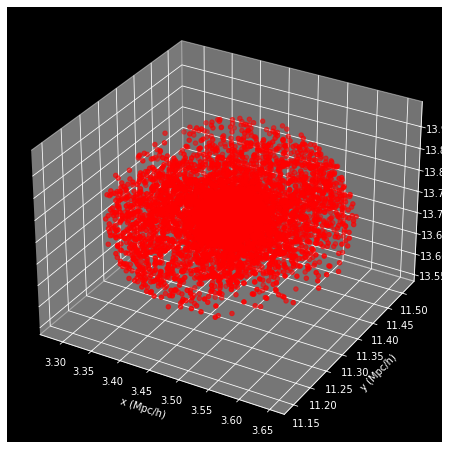

In [4]:
%matplotlib inline
#%matplotlib widget
cache.set_dir(HOMECACHE)
plots.particle_plot(iteration_1)

# Second Iteration: Find Particles at Earlier Times

In [5]:
iteration_2 = [iteration_1]

for i,z in enumerate(REDSHIFTS[1:]):
    
    dataset = ENZO_OUTPUTS[z]
    
    next_stage = pipeline.Stage(
        functions.get_particles_by_id,
        [iteration_1.tag, dataset],
        tag=f"z_{z}_particles_halo_{target_halo_id}",
        depends_on=[iteration_1]
    )

    iteration_2.append( next_stage )

In [6]:
cache.set_dir(SCRATCHCACHE)
gather_iteration_2 = pipeline.Gather(HOMECACHE, iteration_2)
pipeline.execute(gather_iteration_2)

Total runtime: 0:00:00.097516


True

Displaying 83946 particles
Displaying 50306 particles
Displaying 33053 particles
Displaying 22989 particles
Displaying 6455 particles


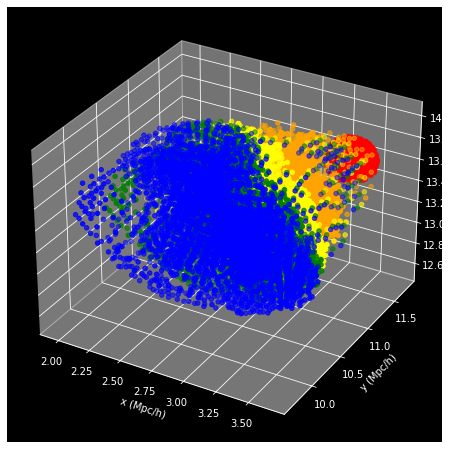

In [7]:
cache.set_dir(HOMECACHE)
plots.multiz_particle_plot(iteration_2)

Colors are blue, green, yellow, orange, red, corresponding to redshifts 6,5,4,3 and 2 respectively.

# Third Iteration: Calculate COM for particles

In [8]:
iteration_3 = []

for i,z in enumerate(REDSHIFTS):
        
    next_stage = pipeline.Stage(
        functions.calc_particle_COM,
        [iteration_2[i].tag],
        tag=f"z_{z}_particle_COM_halo_{target_halo_id}",
        depends_on=[iteration_2[i]]
    )

    iteration_3.append( next_stage )

In [9]:
cache.set_dir(SCRATCHCACHE)
gather_iteration_3 = pipeline.Gather(HOMECACHE, iteration_3)
pipeline.execute(gather_iteration_3)

Total runtime: 0:00:00.084597


True

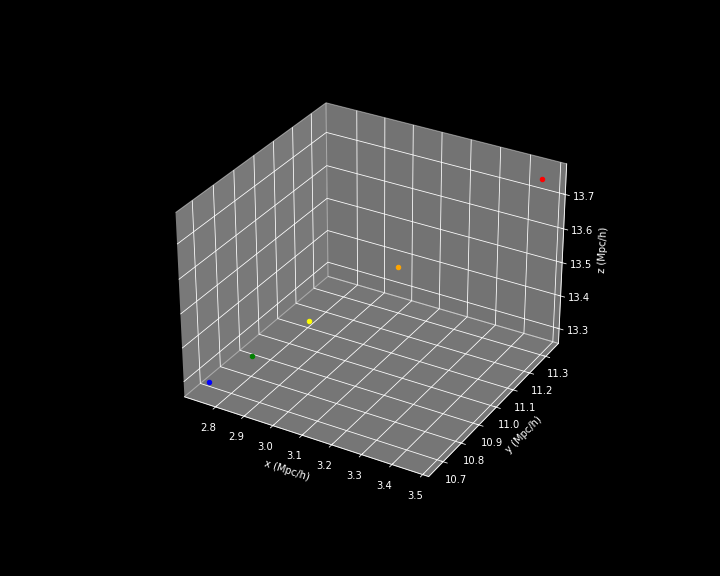

In [10]:
%matplotlib widget
cache.set_dir(HOMECACHE)
plots.position_plot(iteration_3)

# Fourth Iteration: Run the Center Finder algorithm 

In [11]:
iteration_4 = []

for i,z in enumerate(REDSHIFTS):
    
    dataset = ENZO_OUTPUTS[z]
    initial_radius = 1.5/25 # 1.5 Mpccm/h
    threshold = 1 / 256 / (2**7) # size of smallest refined cell in the simulation
    
    args = [
        iteration_3[i].tag,
        dataset,
        initial_radius,
        threshold
    ]
    
    next_stage = pipeline.Stage(
        functions.find_center,
        args,
        tag=f"z_{z}_halo_{target_halo_id}_center",
        depends_on=[iteration_3[i]]
    )

    iteration_4.append( next_stage )

In [12]:
cache.set_dir(SCRATCHCACHE)
gather_iteration_4 = pipeline.Gather(HOMECACHE, iteration_4)
pipeline.execute(gather_iteration_4)

Total runtime: 0:00:00.087172


True

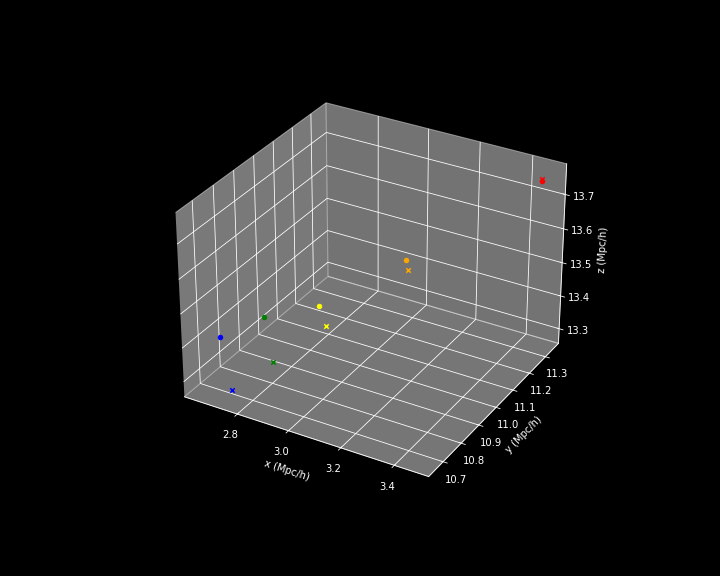

In [13]:
%matplotlib widget
cache.set_dir(HOMECACHE)
plots.centers_plot(iteration_3, iteration_4)

Here x's represent the particle COM initial guess and dots represent the result of the center finder algorithm.

# Final Iteration: Interpolate and Extrapolate to create the tracker file

In [14]:
filename = f"halo_{target_halo_id}_refine_region"
box_length = 1.5/25, # 1.5 Mpccm/h
refine_level = 7
redshift_range = [0,1,2,3,4,5,6]

args = [
    filename,
    target_halo_id,
    redshift_range,
    REDSHIFTS,
    box_length,
    refine_level,
    True,
    ENZO_OUTPUTS[2]
]

iteration_5 = pipeline.Stage(
    functions.create_tracking_file,
    args,
    tag=filename,
    action="manual",
    depends_on=iteration_4
)

# Run the pipeline

In [15]:
cache.set_dir(SCRATCHCACHE)
pipeline.execute(iteration_5)
!cat halo_74_refine_region


Total runtime: 0:00:00.137835
6.00 0.0459222 0.3694245 0.4756129 0.1659222 0.4894245 0.5956129 7
5.00 0.0505842 0.3724718 0.4776439 0.1705842 0.4924718 0.5976439 7
4.00 0.0565020 0.3761598 0.4783981 0.1765020 0.4961598 0.5983981 7
3.00 0.0650534 0.3829972 0.4825174 0.1850534 0.5029972 0.6025174 7
2.00 0.0786209 0.3933741 0.4899330 0.1986209 0.5133741 0.6099330 7
1.00 0.1092646 0.4168115 0.5066820 0.2292646 0.5368115 0.6266820 7
0.00 0.2017733 0.4875657 0.5572446 0.3217733 0.6075657 0.6772446 7


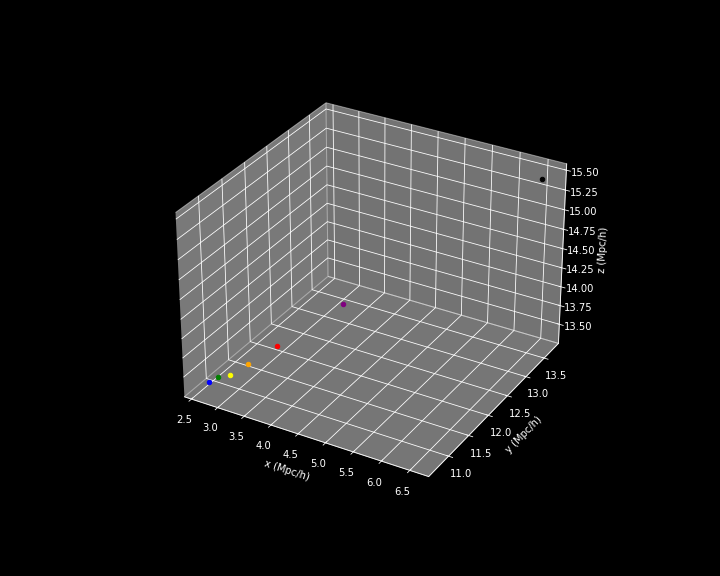

In [16]:
plots.plot_tracking_file(filename)